In [1]:
import tensorflow as tf
import numpy as np
# from censai import PhysicalModel
from censai.data import NISGenerator
from censai.definitions import DTYPE
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, CenteredNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

In [2]:
class BilinearInterpolation(tf.keras.layers.Layer):
    def __init__(self, height=40, width=40):
        super(BilinearInterpolation, self).__init__()
        self.height = height
        self.width = width

    def compute_output_shape(self, input_shape):
        return [None, self.height, self.width, 1]

    def get_config(self):
        return {
            'height': self.height,
            'width': self.width,
        }
    
    def build(self, input_shape):
        print("Building Bilinear Interpolation Layer with input shape:", input_shape)

    def advance_indexing(self, inputs, x, y):
        '''
        Numpy like advance indexing is not supported in tensorflow, hence, this function is a hack around the same method
        '''        
        shape = tf.shape(inputs)
        batch_size = shape[0]
        
        batch_idx = tf.range(0, batch_size)
        batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
        b = tf.tile(batch_idx, (1, self.height, self.width))
        indices = tf.stack([b, y[..., 0], x[..., 0]], 3)
        return tf.gather_nd(inputs, indices)

    def call(self, images , coordinates):
#         images, theta = inputs
#         images , coordinates = inputs
#         homogenous_coordinates = self.grid_generator(batch=tf.shape(images)[0])
#         return self.interpolate(images, homogenous_coordinates, theta)
        return self.interpolate(images, coordinates)

#     def grid_generator(self, batch):
#         x = tf.linspace(-1, 1, self.width)
#         y = tf.linspace(-1, 1, self.height)
            
#         xx, yy = tf.meshgrid(x, y)
#         xx = tf.reshape(xx, (-1,))
#         yy = tf.reshape(yy, (-1,))
#         print(xx.shape)
#         homogenous_coordinates = tf.stack([xx, yy])
#         homogenous_coordinates = tf.cast(homogenous_coordinates, dtype=tf.float32)
#         return homogenous_coordinates
    
#     def interpolate(self, images, homogenous_coordinates, theta):
    def interpolate(self, images, coordinates):
        # coordinates shape = [batch, pixels, pixels, 2]
#         with tf.name_scope("Transformation"):
#             transformed = tf.matmul(theta, homogenous_coordinates)
#             transformed = tf.transpose(transformed, perm=[0, 2, 1])
#             transformed = tf.reshape(transformed, [-1, self.height, self.width, 2])
                
#             x_transformed = transformed[:, :, :, 0]
#             y_transformed = transformed[:, :, :, 1]
                
#             x = ((x_transformed + 1.) * tf.cast(self.width, dtype=tf.float32)) * 0.5
#             y = ((y_transformed + 1.) * tf.cast(self.height, dtype=tf.float32)) * 0.5

        with tf.name_scope("VariableCasting"):
            x, y = tf.split(coordinates, 2, axis=3)
            x0 = tf.cast(tf.math.floor(x), dtype=tf.int32)
            x1 = x0 + 1
            y0 = tf.cast(tf.math.floor(y), dtype=tf.int32)
            y1 = y0 + 1
            
            x0 = tf.clip_by_value(x0, 0, self.width-1)
            x1 = tf.clip_by_value(x1, 0, self.width-1)
            y0 = tf.clip_by_value(y0, 0, self.height-1)
            y1 = tf.clip_by_value(y1, 0, self.height-1)
            x = tf.clip_by_value(x, 0, tf.cast(self.width, dtype=tf.float32)-1.0)
            y = tf.clip_by_value(y, 0, tf.cast(self.height, dtype=tf.float32)-1)

        with tf.name_scope("AdvanceIndexing"):
            Ia = self.advance_indexing(images, x0, y0)
            Ib = self.advance_indexing(images, x0, y1)
            Ic = self.advance_indexing(images, x1, y0)
            Id = self.advance_indexing(images, x1, y1)

        with tf.name_scope("Interpolation"):
            x0 = tf.cast(x0, dtype=tf.float32)
            x1 = tf.cast(x1, dtype=tf.float32)
            y0 = tf.cast(y0, dtype=tf.float32)
            y1 = tf.cast(y1, dtype=tf.float32)
                            
            wa = (x1-x) * (y1-y)
            wb = (x1-x) * (y-y0)
            wc = (x-x0) * (y1-y)
            wd = (x-x0) * (y-y0)

#             wa = tf.expand_dims(wa, axis=3)
#             wb = tf.expand_dims(wb, axis=3)
#             wc = tf.expand_dims(wc, axis=3)
#             wd = tf.expand_dims(wd, axis=3)
                        
        return tf.math.add_n([wa*Ia + wb*Ib + wc*Ic + wd*Id])

In [31]:
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
from censai.definitions import DTYPE

class PhysicalModel:
    """
    Physical model to be passed to RIM class at instantiation
    """
    def __init__(
            self,
            pixels,            # 512
            psf_sigma=0.06,    # gaussian PSF
            src_pixels=None,   # 128 for cosmos
            kappa_pixels=None,
            image_fov=7.68,
            src_fov=3.0,
            kappa_fov=7.68,
            method="conv2d",
            noise_rms=1,
            raytracer=None
    ):
        if src_pixels is None:
            src_pixels = pixels  # assume src has the same shape
        if kappa_pixels is None:
            kappa_pixels = pixels
        self.image_fov = image_fov
        self.psf_sigma = psf_sigma
        self.src_fov = src_fov
        self.pixels = pixels
        self.src_pixels = src_pixels
        self.kappa_pixels = kappa_pixels
        self.kappa_fov = kappa_fov
        self.method = method
        self.noise_rms = noise_rms
        self.raytracer = raytracer
        self.set_deflection_angle_vars()
        self.PSF = self.psf_model()
        if kappa_pixels != pixels:
            self.kappa_to_image_grid = self._kappa_to_image_grid
        else:
            self.kappa_to_image_grid = tf.identity
            
        self.bilinear_interpolation = BilinearInterpolation(src_pixels, src_pixels)

    def deflection_angle(self, kappa):
#         kappa = self.kappa_to_image_grid(kappa)  # resampling to shape of image
        if self.method == "conv2d":
            alpha_x = tf.nn.conv2d(kappa, self.xconv_kernel, [1, 1, 1, 1], "SAME") * (self.dx_kap**2/np.pi)
            alpha_y = tf.nn.conv2d(kappa, self.yconv_kernel, [1, 1, 1, 1], "SAME") * (self.dx_kap**2/np.pi)

        elif self.method == "unet":
            alpha = self.raytracer(kappa)
            alpha_x, alpha_y = tf.split(alpha, 2, axis=-1)

        elif self.method == "fft":
            """
            The convolution using the Convolution Theorem.
            Since we use FFT to justify this approach, we must zero pad the kernel and kappa map to transform 
            a 'circular convolution' (assumed by our use of FFT) into an an 'acyclic convolution' 
            (sum from m=0 to infinity).
            
            To do that, we pad our signal with N-1 trailing zeros for each dimension. N = 2*pixels+1 since 
            our kernel has this shape.
            
            This approach has complexity O((4*pixels)^2 * log^2(4 * pixels)), and is precise to about rms=2e-5 of the 
            true convolution for the deflection angles.
            """
            # pad the kernel and compute itf fourier transform
            xconv_kernel = tf.image.pad_to_bounding_box(self.xconv_kernel[..., 0], 0, 0, 4*self.pixels+1, 4*self.pixels+1)
            yconv_kernel = tf.image.pad_to_bounding_box(self.yconv_kernel[..., 0], 0, 0, 4*self.pixels+1, 4*self.pixels+1)
            x_kernel_tilde = tf.signal.fft2d(tf.cast(-xconv_kernel[..., 0], tf.complex64))
            y_kernel_tilde = tf.signal.fft2d(tf.cast(-yconv_kernel[..., 0], tf.complex64))

            batch_size = kappa.shape[0]
            alpha_x = tf.TensorArray(dtype=DTYPE, size=batch_size)
            alpha_y = tf.TensorArray(dtype=DTYPE, size=batch_size)
            for i in range(batch_size):
                kap = tf.image.pad_to_bounding_box(kappa[i, ...],  # pad kappa one by one to save memory space
                                                   offset_height=0,
                                                   offset_width=0,
                                                   target_width=4 * self.pixels + 1,
                                                   target_height=4 * self.pixels + 1)
                kappa_tilde = tf.signal.fft2d(tf.cast(kap[..., 0], tf.complex64))
                alpha_x = alpha_x.write(index=i, value=tf.math.real(tf.signal.ifft2d(kappa_tilde * x_kernel_tilde)) * (self.dx_kap**2/np.pi))
                alpha_y = alpha_y.write(index=i, value=tf.math.real(tf.signal.ifft2d(kappa_tilde * y_kernel_tilde)) * (self.dx_kap**2/np.pi))
            alpha_x = alpha_x.stack()[..., tf.newaxis]
            alpha_x = tf.image.crop_to_bounding_box(alpha_x,
                                                    offset_height=self.pixels,
                                                    offset_width=self.pixels,
                                                    target_width=self.pixels,
                                                    target_height=self.pixels)
            alpha_y = alpha_y.stack()[..., tf.newaxis]
            alpha_y = tf.image.crop_to_bounding_box(alpha_y,
                                                    offset_height=self.pixels,
                                                    offset_width=self.pixels,
                                                    target_width=self.pixels,
                                                    target_height=self.pixels)
        else:
            raise ValueError(f"{self.method} is not in [conv2d, unet, fft]")
        return alpha_x, alpha_y

    def log_likelihood(self, source, kappa, y_true):
        y_pred = self.forward(source, kappa)
        # lam = self.lagrange_multiplier(y_true, y_pred)
        # return 0.5 * tf.reduce_mean((y_pred - lam * y_true)**2/self.noise_rms**2, axis=(1, 2, 3))
        return 0.5 * tf.reduce_mean((y_pred - y_true) ** 2 / self.noise_rms ** 2, axis=(1, 2, 3))

    @staticmethod
    def lagrange_multiplier(y_true, y_pred):
        return tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3), keepdims=True) / tf.reduce_sum(y_true**2, axis=(1, 2, 3), keepdims=True)

    def forward(self, source, kappa):
        im = self.lens_source(source, kappa)
#         im = self.convolve_with_psf(im)
        return im

    def noisy_forward(self, source, kappa, noise_rms):
        im = self.lens_source(source, kappa)
        noise = tf.random.normal(im.shape, mean=0, stddev=noise_rms)
#         out = self.convolve_with_psf(im)  # convolve before adding noise, otherwise it correlates the noise
#         out = out + noise
        return im + noise

    def lens_source(self, source, kappa):
        dx_kap = self.kappa_fov / (self.pixels - 1)
        # Convolution kernel
        x = tf.linspace(-1, 1, 2 * self.pixels + 1) * self.kappa_fov
        xx, yy = tf.meshgrid(x, x)
        rho = xx**2 + yy**2
        xconv_kernel = -self._safe_divide(xx, rho)
        yconv_kernel = -self._safe_divide(yy, rho)
        # reshape to [filter_height, filter_width, in_channels, out_channels]
        xconv_kernel = tf.cast(xconv_kernel[..., tf.newaxis, tf.newaxis], dtype=DTYPE)
        yconv_kernel = tf.cast(yconv_kernel[..., tf.newaxis, tf.newaxis], dtype=DTYPE)

        # coordinates for image
        ximage = tf.cast(xx[tf.newaxis, self.pixels//2:3*self.pixels//2, self.pixels//2:3*self.pixels//2, tf.newaxis], dtype=DTYPE)
        yimage = tf.cast(yy[tf.newaxis, self.pixels//2:3*self.pixels//2, self.pixels//2:3*self.pixels//2, tf.newaxis], dtype=DTYPE)
        alpha_x = tf.nn.conv2d(kappa, xconv_kernel, [1, 1, 1, 1], "SAME") * (dx_kap**2/np.pi)
        alpha_y = tf.nn.conv2d(kappa, yconv_kernel, [1, 1, 1, 1], "SAME") * (dx_kap**2/np.pi)
        beta1 = ximage - alpha_x
        beta2 = yimage - alpha_y
#         print(tf.reduce_max(tf.abs(beta1)).numpy(), tf.reduce_max(tf.abs(beta2)).numpy(), tf.reduce_min(tf.abs(beta1)).numpy(), tf.reduce_min(tf.abs(beta2)).numpy())
    
#         x_src_pix, y_src_pix = self.src_coord_to_pix(beta1, beta2, tf.reduce_max(tf.abs(beta1)).numpy(), tf.reduce_max(tf.abs(beta2)).numpy())
        x_src_pix, y_src_pix = self.src_coord_to_pix(beta1, beta2)
        warp = tf.concat([x_src_pix, y_src_pix], axis=-1)
#         im = tfa.image.resampler(source, warp)  # bilinear interpolation of source on warp grid
        im = self.bilinear_interpolation(source, warp)
        return im


    def src_coord_to_pix(self, x, y, xmax, ymax):
        dx = 2 * xmax / (self.src_pixels - 1)
        dy = 2 * ymax / (self.src_pixels - 1)
        xmin = - xmax
        ymin = - ymax
        i_coord = (x - xmin) / dx
        j_coord = (y - ymin) / dy
        return i_coord, j_coord
    
    def src_coord_to_pix(self, x, y):
        dx = self.src_fov / (self.src_pixels - 1)
        xmin = -0.5 * self.src_fov
        ymin = -0.5 * self.src_fov
        i_coord = (x - xmin) / dx
        j_coord = (y - ymin) / dx
        return i_coord, j_coord

    def kap_coord_to_pix(self, x, y):
        dx = self.kappa_fov / (self.kappa_pixels - 1)
        xmin = -0.5 * self.kappa_fov
        ymin = -0.5 * self.kappa_fov
        i_coord = (x - xmin) / dx
        j_coord = (y - ymin) / dx
        return i_coord, j_coord

    def _kappa_to_image_grid(self, kappa):
        batch_size = kappa.shape[0]
        x_coord, y_coord = self.kap_coord_to_pix(self.xkappa, self.ykappa)
        warp = tf.concat([x_coord, y_coord], axis=-1)
        warp = tf.tile(warp, [batch_size, 1, 1, 1])  # make sure warp has same batch size has kappa
        kappa = tfa.image.resampler(kappa, warp)
        return kappa

    def set_deflection_angle_vars(self):
        self.dx_kap = self.kappa_fov / (self.pixels - 1)  # dx on image grid

        # Convolution kernel
        x = tf.linspace(-1, 1, 2 * self.pixels + 1) * self.kappa_fov
        xx, yy = tf.meshgrid(x, x)
        rho = xx**2 + yy**2
        xconv_kernel = -self._safe_divide(xx, rho)
        yconv_kernel = -self._safe_divide(yy, rho)
        # reshape to [filter_height, filter_width, in_channels, out_channels]
        self.xconv_kernel = tf.cast(xconv_kernel[..., tf.newaxis, tf.newaxis], dtype=DTYPE)
        self.yconv_kernel = tf.cast(yconv_kernel[..., tf.newaxis, tf.newaxis], dtype=DTYPE)

        # coordinates for image
        x = tf.linspace(-1, 1, self.pixels) * self.image_fov / 2
        xx, yy = tf.meshgrid(x, x)
        # reshape for broadcast to [batch_size, pixels, pixels, 1]
        self.ximage = tf.cast(xx[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)
        self.yimage = tf.cast(yy[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)

        # Coordinates for kappa
        xkappa = tf.cast(tf.linspace(-1, 1, self.pixels), dtype=DTYPE) * self.kappa_fov / 2
        xkappa, ykappa = tf.meshgrid(xkappa, xkappa)
        self.xkappa = tf.cast(xkappa[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)
        self.ykappa = tf.cast(ykappa[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)


    @staticmethod
    def _safe_divide(num, denominator):
        out = np.zeros_like(num)
        out[denominator != 0] = num[denominator != 0] / denominator[denominator != 0]
        return out

    def psf_model(self):
        pixel_scale = self.image_fov / self.pixels
        cutout_size = int(10 * self.psf_sigma / pixel_scale)
        r_squared = self.ximage**2 + self.yimage**2
        psf = tf.math.exp(-0.5 * r_squared / self.psf_sigma**2)
        psf = tf.image.crop_to_bounding_box(psf,
                                            offset_height=self.pixels//2 - cutout_size//2,
                                            offset_width=self.pixels//2 - cutout_size//2,
                                            target_width=cutout_size,
                                            target_height=cutout_size)
        psf /= tf.reduce_sum(psf)
        psf = tf.reshape(psf, shape=[cutout_size, cutout_size, 1, 1])
        return psf

    def convolve_with_psf(self, images):
        convolved_images = tf.nn.conv2d(images, self.PSF, [1, 1, 1, 1], padding="SAME")
        return convolved_images


In [32]:
noise_rms = 0.01

kappa_gen = NISGenerator(
    kappa_fov=17.425909,
    src_fov=3,
    pixels=128,
)
phys = PhysicalModel(kappa_fov=17.425909, image_fov=17.425909, kappa_pixels=128, pixels=128, src_fov=3, src_pixels=128, method="fft")

xsrc = tf.cast(tf.linspace(-1, 1, phys.src_pixels), dtype=DTYPE) * phys.src_fov / 2
xsrc, ysrc = tf.meshgrid(xsrc, xsrc)
xsrc = tf.cast(xsrc[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)
ysrc = tf.cast(ysrc[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)

In [33]:
# kappa
r = 0.
theta = 0.
x0 = r * tf.math.cos(theta)
y0 = r * tf.math.sin(theta)
ellipticity = 0.
phi = 0.
einstein_radius = 5
kappa = kappa_gen.kappa_field(x0, y0, ellipticity, phi, einstein_radius)[None, ...]

# source
r = 0.2
theta = 0.
xs = r * tf.math.cos(theta)
ys = r * tf.math.sin(theta)
es = 0.
w = 0.1
rho_sq = (xsrc - xs) ** 2 / (1 - es) + (ysrc - ys) ** 2 * (1 - es)
source = tf.math.exp(-0.5 * rho_sq / w ** 2)  # / 2 / np.pi / w**2
source /= tf.reduce_max(source, axis=(1, 2, 3), keepdims=True)

# lens
X = phys.noisy_forward(source, kappa, noise_rms=noise_rms)
X = tf.nn.relu(X)
X /= tf.reduce_max(X, axis=(1, 2, 3), keepdims=True)

Building Bilinear Interpolation Layer with input shape: (1, 128, 128, 1)


In [34]:
# phys.kappa_fov=20
# phys.image_fov=20
# phys.forward_method = "fft"

lensed_image = X
batch_size = lensed_image.shape[0]

with tf.GradientTape() as g:
    g.watch(source)
    g.watch(kappa)
    y_pred = phys.forward(source=source, kappa=kappa)
    log_likelihood = 0.5 * tf.reduce_sum((y_pred - lensed_image) ** 2 / phys.noise_rms ** 2, axis=(1, 2, 3))
    cost = tf.reduce_mean(log_likelihood)
source_grad, kappa_grad = g.gradient(cost, [source, kappa])
# source_grad, kappa_grad = [tf.clip_by_value(grad/100, -10, 10) for grad in [source_grad, kappa_grad]]

In [35]:
# phys.kappa_fov=20
# phys.image_fov=20
# phys.forward_method = "fft"

source_init = 1
# kappa_init = tf.math.log(0.9 + 1e-8)/tf.math.log(10.)
kappa_init = 0.4


lensed_image = X
batch_size = lensed_image.shape[0]

source_i = tf.ones_like(source, dtype=DTYPE) * source_init
kappa_i = tf.ones_like(kappa, dtype=DTYPE) * kappa_init

with tf.GradientTape() as g:
    g.watch(source_i)
    g.watch(kappa_i)
#     y_pred = phys.forward(source=source_i, kappa=10**kappa_i)
    y_pred = phys.forward(source=source_i, kappa=kappa_i)
    log_likelihood = 0.5 * tf.reduce_sum((y_pred - lensed_image) ** 2 / phys.noise_rms ** 2, axis=(1, 2, 3))
    cost = tf.reduce_mean(log_likelihood)
source_i_grad, kappa_i_grad = g.gradient(cost, [source_i, kappa_i])
# source_grad, kappa_grad = [tf.clip_by_value(grad/100, -10, 10) for grad in [source_grad, kappa_grad]]

(-0.5, 127.5, 127.5, -0.5)

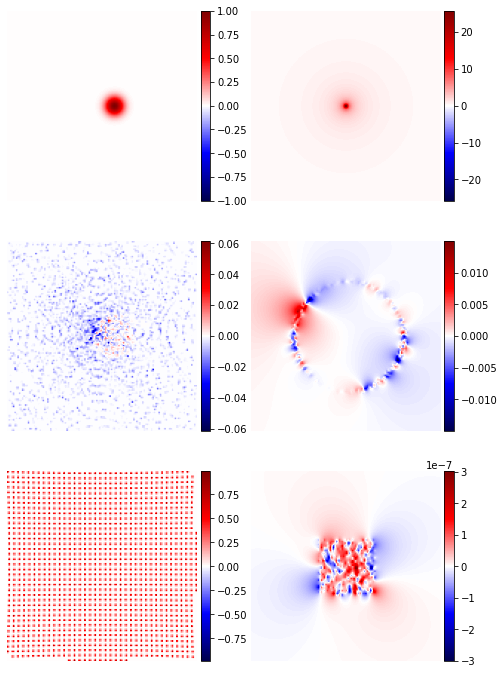

In [36]:
fig, axs =  plt.subplots(3, 2, figsize=(8, 12))

ax = axs[0, 0]
im = ax.imshow(source[0, ..., 0], cmap="seismic", norm=CenteredNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.axis("off")

ax = axs[0, 1]
im = ax.imshow(kappa[0, ..., 0], cmap="seismic", norm=CenteredNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.axis("off")

ax = axs[1, 0]
im = ax.imshow(source_grad[0, ..., 0], cmap="seismic", norm=CenteredNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.axis("off")

ax = axs[1, 1]
im = ax.imshow(kappa_grad[0, ..., 0], cmap="seismic", norm=CenteredNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.axis("off")

ax = axs[2, 0]
im = ax.imshow(source_i_grad[0, ..., 0], cmap="seismic", norm=CenteredNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.axis("off")

ax = axs[2, 1]
im = ax.imshow(kappa_i_grad[0, ..., 0], cmap="seismic", norm=CenteredNorm())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.axis("off")

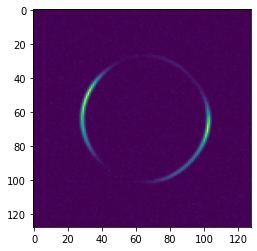

In [37]:
plt.imshow(X[0, ..., 0])

In [40]:
# phys.kappa_fov=20
# phys.image_fov=20
# phys.forward_method = "fft"

source_init = 1
kappa_init = [tf.math.log(k + 1e-8)/tf.math.log(10.) for k in tf.linspace(0.1, 2, 20)]
# kappa_init = [k for k in tf.linspace(0.1, 2, 3)]


lensed_image = X
batch_size = lensed_image.shape[0]

# source_i = tf.random.uniform(shape=source.shape, dtype=DTYPE)
source_i = tf.ones_like(source, dtype=DTYPE)
kappa_i = tf.ones_like(kappa, dtype=DTYPE)

source_i_grad = []
kappa_i_grad = []

for ki in tqdm(kappa_init):
    k = kappa_i*ki
    with tf.GradientTape() as g:
        g.watch(source_i)
        g.watch(k)
        y_pred = phys.forward(source=source_i, kappa=10**(k))
        log_likelihood = 0.5 * tf.reduce_sum((y_pred - lensed_image) ** 2 / phys.noise_rms ** 2, axis=(1, 2, 3))
        cost = tf.reduce_mean(log_likelihood)
    _source_i_grad, _kappa_i_grad = g.gradient(cost, [source_i, k])
    source_i_grad.append(_source_i_grad)
    kappa_i_grad.append(_kappa_i_grad)
# source_grad, kappa_grad = [tf.clip_by_value(grad/100, -10, 10) for grad in [source_grad, kappa_grad]]

100%|██████████| 20/20 [04:29<00:00, 13.48s/it]


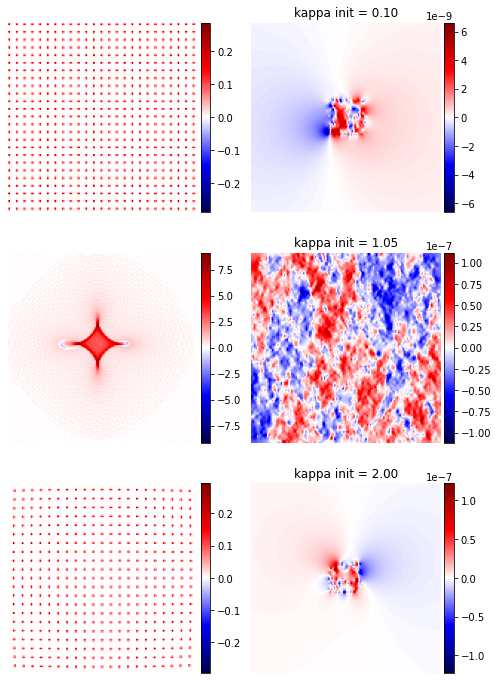

In [39]:
# fig, axs =  plt.subplots(3, 2, figsize=(8, 12))
# for i in range(3):
#     ax = axs[i, 0]
#     im = ax.imshow(source_i_grad[i][0, ..., 0], cmap="seismic", norm=CenteredNorm())
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     plt.colorbar(im, cax=cax)
#     ax.axis("off")

#     ax = axs[i, 1]
#     ax.set_title(f"kappa init = {10**kappa_init[i]:.2f}")
#     im = ax.imshow(kappa_i_grad[i][0, ..., 0], cmap="seismic", norm=CenteredNorm())
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     plt.colorbar(im, cax=cax)
#     ax.axis("off")

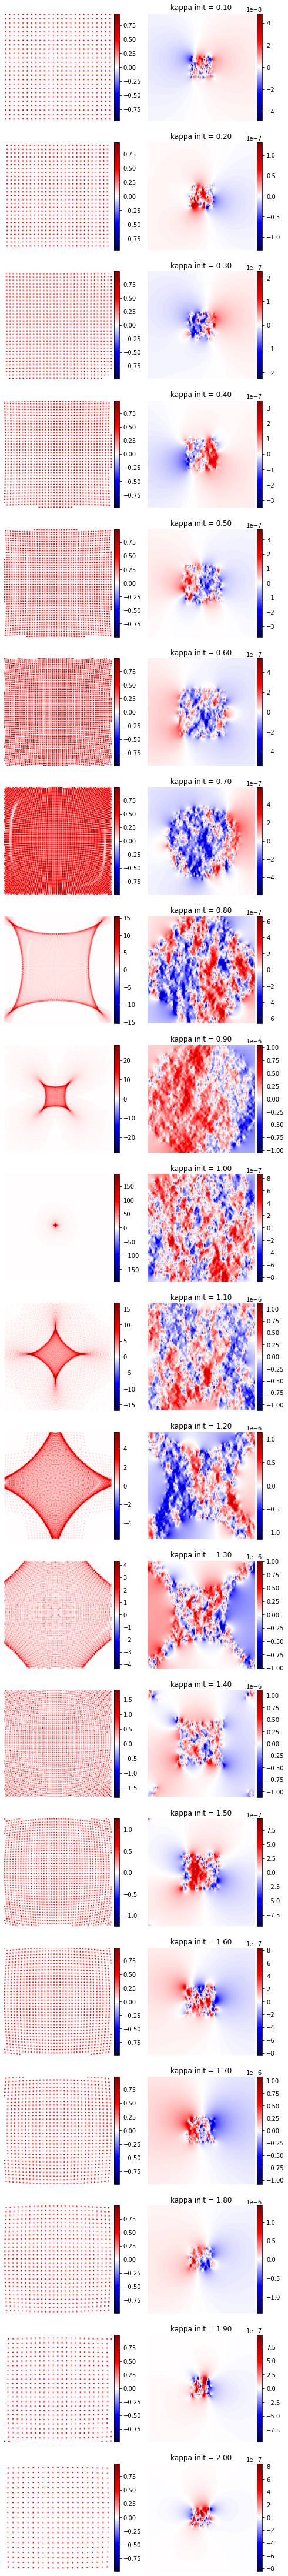

In [43]:
fig, axs =  plt.subplots(20, 2, figsize=(8, 80))
for i in range(20):
    ax = axs[i, 0]
    im = ax.imshow(source_i_grad[i][0, ..., 0], cmap="seismic", norm=CenteredNorm())
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.axis("off")

    ax = axs[i, 1]
    ax.set_title(f"kappa init = {10**kappa_init[i]:.2f}")
    im = ax.imshow(kappa_i_grad[i][0, ..., 0], cmap="seismic", norm=CenteredNorm())
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.axis("off")

In [210]:
# phys.kappa_fov=20
# phys.image_fov=20
# phys.forward_method = "fft"

source_init = 1
kappa_init = [tf.math.log(k + 1e-8)/tf.math.log(10.) for k in tf.linspace(0.1, 1., 5)]

lensed_image = X
batch_size = lensed_image.shape[0]

xsrc2 = tf.cast(tf.linspace(-1, 1, phys.src_pixels), dtype=DTYPE) * phys.src_fov / 2
xsrc2, ysrc2 = tf.meshgrid(xsrc2, xsrc2)
xsrc2 = tf.cast(xsrc2[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)
ysrc2 = tf.cast(ysrc2[tf.newaxis, ..., tf.newaxis], dtype=DTYPE)

source_i = tf.ones_like(source, dtype=DTYPE) #* xsrc2 / tf.reduce_max(xsrc2)
# source_i = tf.random.uniform(shape=source.shape, dtype=DTYPE) #* source_init
kappa_i = tf.ones_like(kappa, dtype=DTYPE)

source_i_grad = []
kappa_i_grad = []

for ki in tqdm(kappa_init):
    k = kappa_i*ki
    with tf.GradientTape() as g:
        g.watch(source_i)
        g.watch(k)
        y_pred = phys.forward(source=source_i, kappa=10**(k))
        log_likelihood = 0.5 * tf.reduce_sum((y_pred - lensed_image) ** 2 / phys.noise_rms ** 2, axis=(1, 2, 3))
        cost = tf.reduce_mean(log_likelihood)
    _source_i_grad, _kappa_i_grad = g.gradient(cost, [source_i, k])
    source_i_grad.append(_source_i_grad)
    kappa_i_grad.append(_kappa_i_grad)
# source_grad, kappa_grad = [tf.clip_by_value(grad/100, -10, 10) for grad in [source_grad, kappa_grad]]

100%|██████████| 5/5 [01:08<00:00, 13.65s/it]


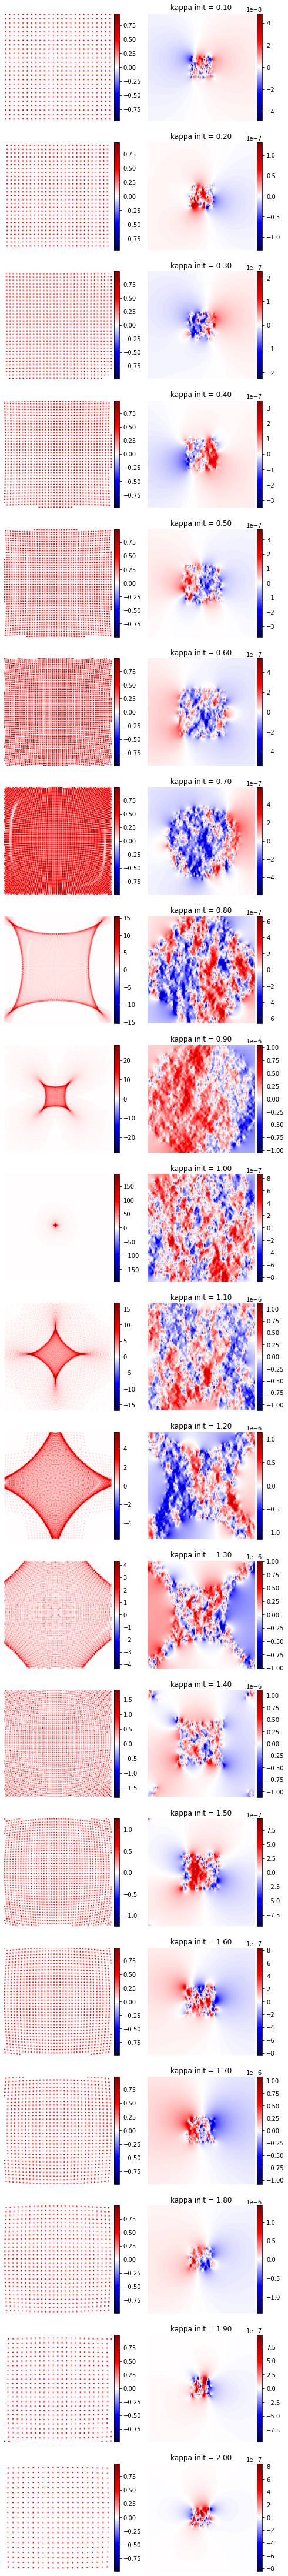

In [42]:
fig, axs =  plt.subplots(5, 2, figsize=(8, 20))
for i in range(5):
    ax = axs[i, 0]
    im = ax.imshow(source_i_grad[i][0, ..., 0], cmap="seismic", norm=CenteredNorm())
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.axis("off")

    ax = axs[i, 1]
    ax.set_title(f"kappa init = {10**kappa_init[i]:.2f}")
    im = ax.imshow(kappa_i_grad[i][0, ..., 0], cmap="seismic", norm=CenteredNorm())
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.axis("off")

In [26]:
# phys.kappa_fov=20
# phys.image_fov=20
phys.forward_method = "conv2d"

# source_init = 1
# source
r = 0.2
theta = 0.
xs = r * tf.math.cos(theta)
ys = r * tf.math.sin(theta)
es = 0.
w = 0.1
rho_sq = (xsrc - xs) ** 2 / (1 - es) + (ysrc - ys) ** 2 * (1 - es)
source_i = tf.math.exp(-0.5 * rho_sq / w ** 2)  # / 2 / np.pi / w**2
source_i /= tf.reduce_max(source, axis=(1, 2, 3), keepdims=True)


rei = tf.cast(tf.linspace(1, 5, 20), DTYPE)

lensed_image = X
batch_size = lensed_image.shape[0]

# source_i = tf.ones_like(source, dtype=DTYPE) * source_init

# kappa_i = tf.ones_like(kappa, dtype=DTYPE)

source_i_grad = []
kappa_i_grad = []

for re in tqdm(rei):
    kappa_i = tf.math.log(kappa_gen.kappa_field(-2, 0., 0., 0., re)[None, ...] + 1e-8)/tf.math.log(10.)
    with tf.GradientTape() as g:
        g.watch(source_i)
        g.watch(kappa_i)
        y_pred = phys.lens_source(source=source_i, kappa=10**(kappa_i))
        log_likelihood = 0.5 * tf.reduce_sum((y_pred - lensed_image) ** 2 / phys.noise_rms ** 2, axis=(1, 2, 3))
        cost = tf.reduce_mean(log_likelihood)
    _source_i_grad, _kappa_i_grad = g.gradient(cost, [source_i, kappa_i])
    source_i_grad.append(_source_i_grad)
    kappa_i_grad.append(_kappa_i_grad)
# source_grad, kappa_grad = [tf.clip_by_value(grad/100, -10, 10) for grad in [source_grad, kappa_grad]]

100%|██████████| 20/20 [04:28<00:00, 13.41s/it]


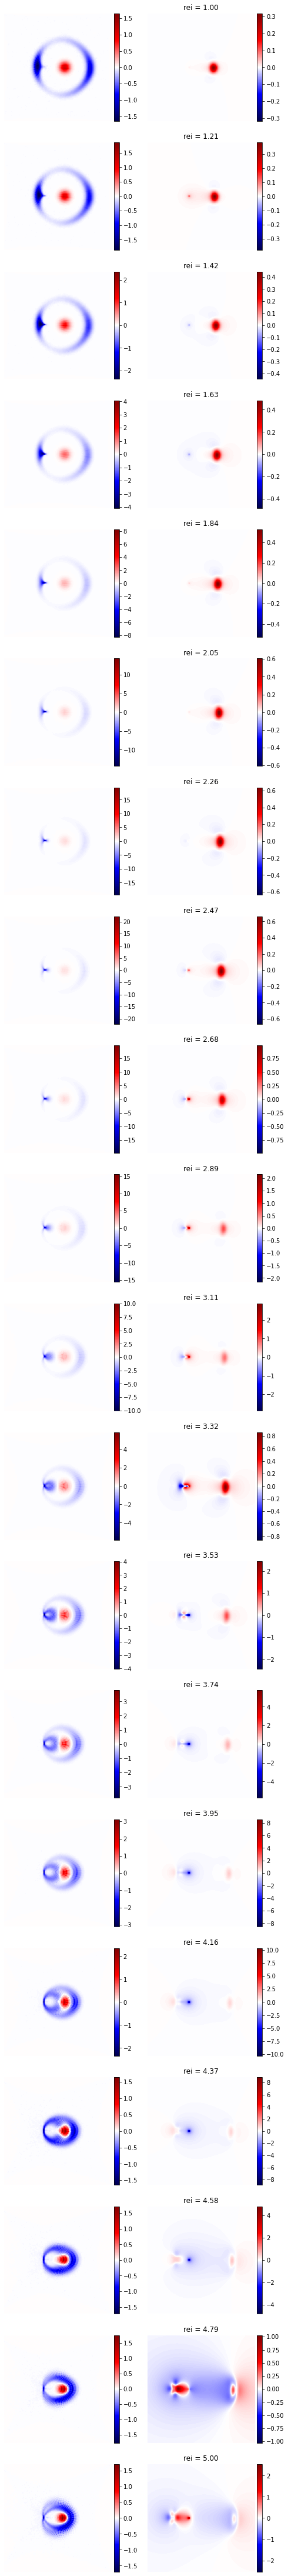

In [27]:
fig, axs =  plt.subplots(20, 2, figsize=(8, 80))
for i in range(20):
    ax = axs[i, 0]
    im = ax.imshow(source_i_grad[i][0, ..., 0], cmap="seismic", norm=CenteredNorm())
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.axis("off")

    ax = axs[i, 1]
    ax.set_title(f"rei = {rei[i].numpy():.2f}")
    im = ax.imshow(kappa_i_grad[i][0, ..., 0], cmap="seismic", norm=CenteredNorm())
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.axis("off")